In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Load dataset
image_array = np.loadtxt('../Data Cleaning & Transformation/Data/image_array.csv', delimiter=',')
labels = np.loadtxt('../Data Cleaning & Transformation/Data/image_label_array.csv', delimiter=',', dtype=str)

# 1. Train-Test Split

In [3]:
# Randomly shuffle the indices
indices = np.random.permutation(image_array.shape[0])
size = round(indices.shape[0]*0.8)
training_idx, test_idx = indices[:size], indices[size:]

# Split the data
training_X, test_X = image_array[training_idx,:], image_array[test_idx,:]
training_y, test_y = labels[training_idx], labels[test_idx]

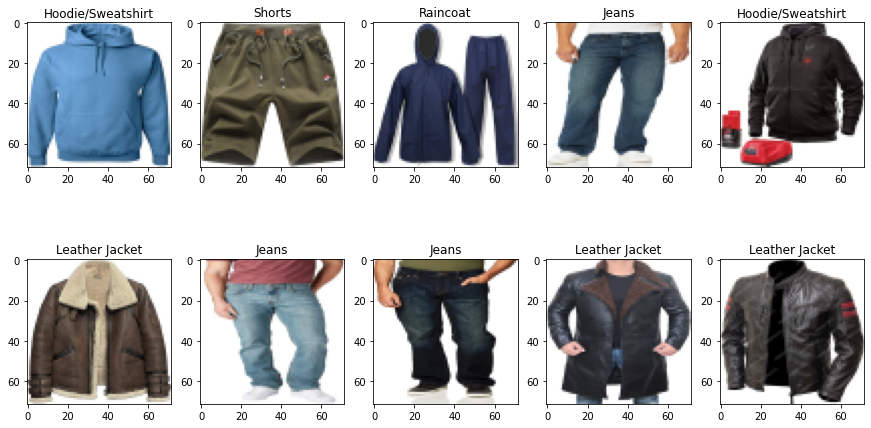

In [4]:
randomlist = random.sample(range(0,test_X.shape[0]), 5)

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    img_temp_1 = training_X[randomlist[i]].reshape(72,72,3)
    plt.imshow(img_temp_1.astype('uint8'))
    plt.title(training_y[randomlist[i]])
    plt.subplot(2,5,i+6)
    img_temp_2 = test_X[randomlist[i]].reshape(72,72,3)
    plt.imshow(img_temp_2.astype('uint8'))
    plt.title(test_y[randomlist[i]])
plt.show()

# 2. Data Transformation

### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(training_y)
# Hold the classes as list for visualizing and application building later
label_order = list(label_encoder.classes_)

### Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler((0,1))
scaled_train = scaler.fit_transform(training_X)

## 2.1 Reducing the data

### PCA

In [8]:
from sklearn.decomposition import PCA

# Account for 99% of variance
pca = PCA(0.99)
# Transformed image
pca_transformed = pca.fit_transform(scaled_train)

print(f'{scaled_train.shape[1]} features has been reduced to {pca_transformed.shape[1]}')

15552 features has been reduced to 469


In [9]:
# Inverese the PCA transformed to original for display
inversed_2d = pca.inverse_transform(pca_transformed)
inveresed_3d = inversed_2d.reshape(inversed_2d.shape[0], 72, 72, 3)

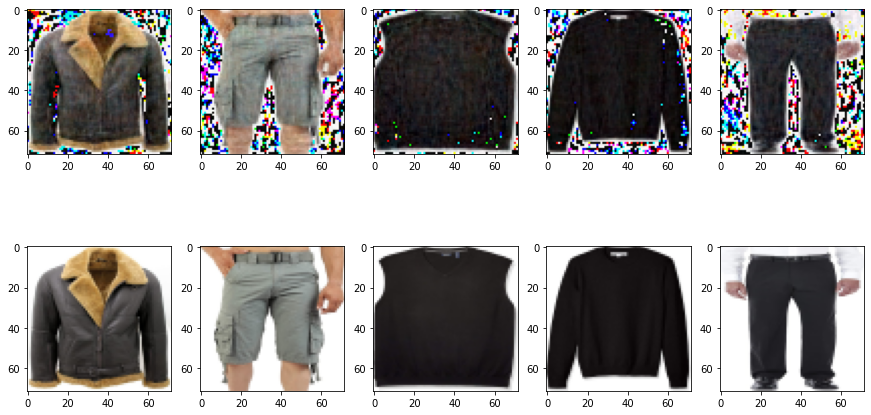

In [10]:
# Compare and display 5 inversed PCA images and its original images
randomlist = random.sample(range(0,inveresed_3d.shape[0]), 5)

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    img_temp_1 = inveresed_3d[randomlist[i]]*255
    plt.imshow(img_temp_1.astype('uint8'))
    #plt.imshow(inveresed_3d[randomlist[i], :])
    plt.subplot(2,5,i+6)
    img_temp_2 = training_X[randomlist[i]].reshape(72,72,3)
    plt.imshow(img_temp_2.astype('uint8'))
    #plt.imshow(training_idx[randomlist[i], :])
plt.show()

### LDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [12]:
# Performing LDA on multi-label classification
lda = LinearDiscriminantAnalysis()
lda.fit(scaled_train, y_train_label)
lda_transformed = lda.transform(scaled_train)

print(f'{scaled_train.shape[1]} features has been reduced to {lda_transformed.shape[1]}')

15552 features has been reduced to 9


## 3. Modelling

## 3.1 Model selection

#### PCA

In [13]:
#importing libraries of machine learning algorithm 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [14]:
log = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
forest = RandomForestClassifier()
scv = SVC()

models_pca = [('LR', log),
          ('KNN',knn),
          ('Naive Bayes',naive_bayes),
          ('Random Forest',forest),
          ('SVM',scv)]

In [15]:
# Train all models 
for name, model in models_pca:
    model.fit(pca_transformed,y_train_label)
    print(f'Trained {name}')

Trained LR
Trained KNN
Trained Naive Bayes
Trained Random Forest
Trained SVM


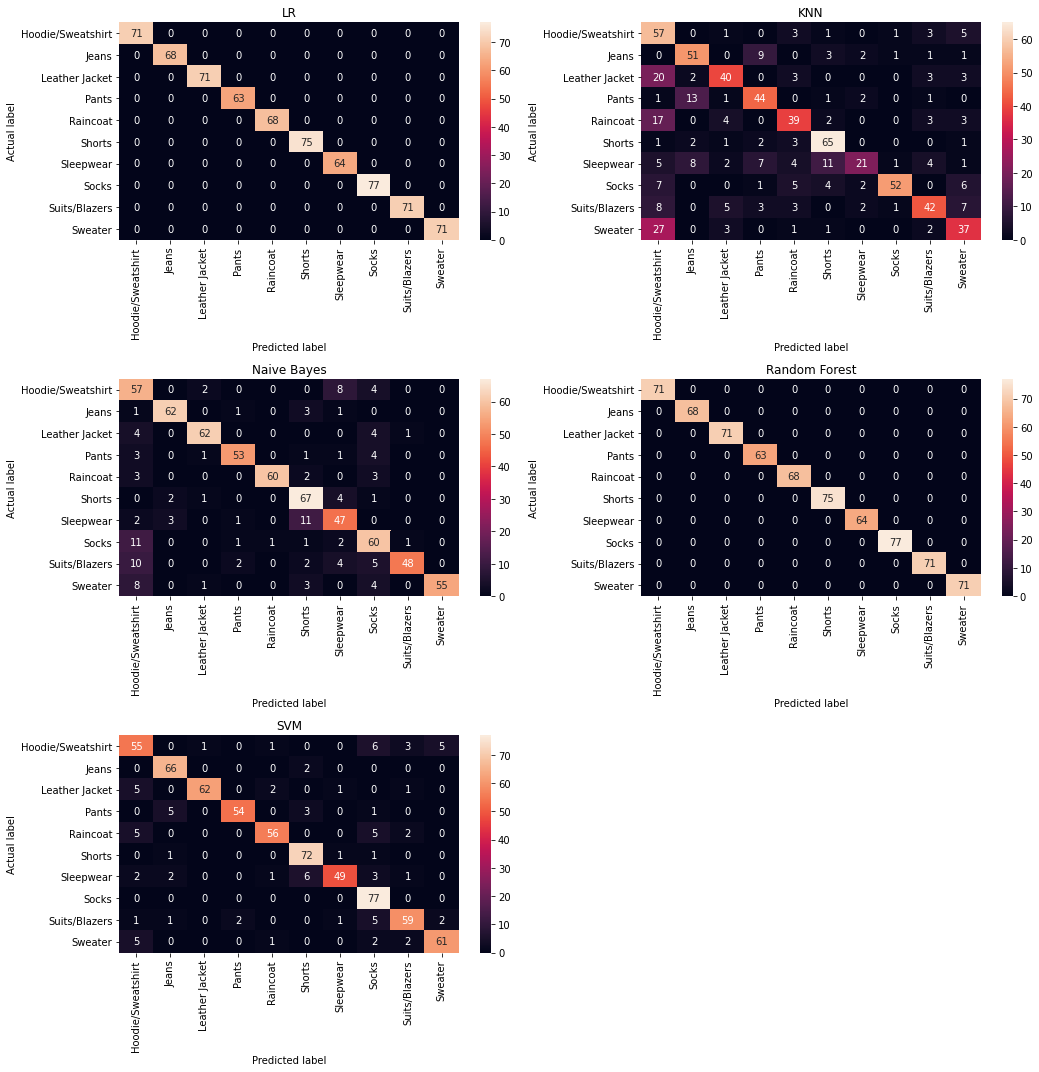

In [16]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(15,15))
for i, model in enumerate(models_pca):
    plt.subplot(3,2,i+1)
    y_predict = model[1].predict(pca_transformed)
    cmatrix = confusion_matrix(y_train_label,y_predict)
    # create heatmap
    sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
    plt.title(model[0])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#### LDA

In [17]:
log = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
forest = RandomForestClassifier()
scv = SVC()

models_lda = [('LR', log),
          ('KNN',knn),
          ('Naive Bayes',naive_bayes),
          ('Random Forest',forest),
          ('SVM',scv)]

In [18]:
# Train all models 
for name, model in models_lda:
    model.fit(lda_transformed,y_train_label)
    print(f'Trained {name}')

Trained LR
Trained KNN
Trained Naive Bayes
Trained Random Forest
Trained SVM


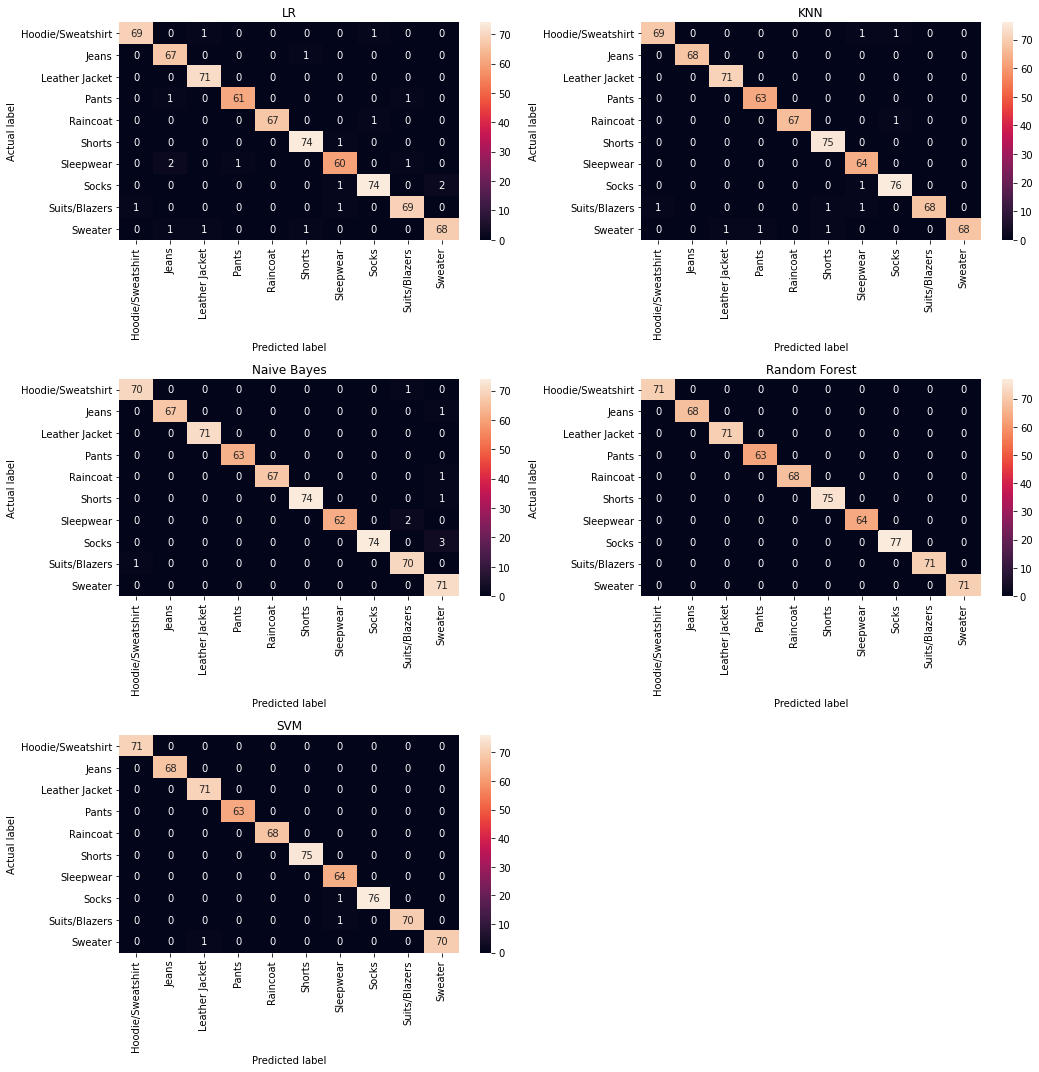

In [19]:
plt.figure(figsize=(15,15))
for i, model in enumerate(models_lda):
    plt.subplot(3,2,i+1)
    y_predict = model[1].predict(lda_transformed)
    cmatrix = confusion_matrix(y_train_label,y_predict)
    
    # create heatmap
    sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
    plt.title(model[0])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 3.2 Cross-Validation

#### PCA

In [20]:
from sklearn.model_selection import cross_val_score

acc_score = []
f1_score = []
model_name = []

#Creating a DataFrame to store performance of each model
df_results = pd.DataFrame(columns=['Name','F1 Mean','F1 STD',
                                   'Accuracy Mean','Accuracy STD'])

#Performing cross validation for each model to find the best model
i=0
for name,model in models_pca:
    #Cross Validation
    accuracy = cross_val_score(model,pca_transformed,y_train_label,cv=10,
                             scoring='accuracy',
                            n_jobs=-1,verbose=10)

    f1 = cross_val_score(model,pca_transformed,y_train_label,cv=10,
                             scoring='f1_weighted',
                            n_jobs=-1,verbose=10)
    #Appending the result to list
    acc_score.append(accuracy)
    f1_score.append(f1)
    model_name.append(name)
    #Appending the performance to the Dataframe
    df_results.loc[i] = [name,
                         f1.mean(),
                         f1.std(),
                         accuracy.mean(),
                         accuracy.std()]
    i += 1
#Displaying the performance of the cross validation    
df_results.sort_values(by=['F1 Mean'],ascending=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   23.9s remaining:   55.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   24.6s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   24.7s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   17.1s remaining:   40.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   17.4s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s r

,Name,F1 Mean,F1 STD,Accuracy Mean,Accuracy STD
4,SVM,0.565862,0.052106,0.577992,0.047688
1,KNN,0.477340,0.043034,0.486501,0.042059
0,LR,0.432741,0.026205,0.443499,0.030028
3,Random Forest,0.371280,0.033982,0.410559,0.035830
2,Naive Bayes,0.343298,0.034728,0.363395,0.035851


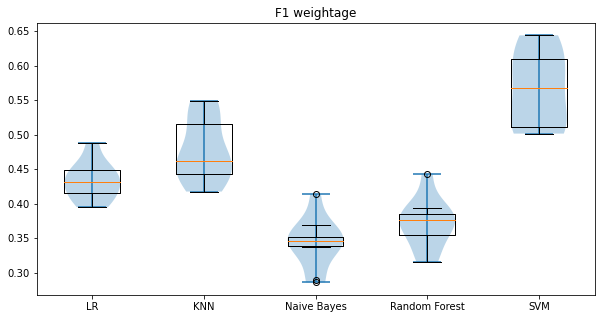

In [21]:
#Plotting the test results as boxplot
plt.figure(figsize=(10,5))
plt.violinplot(f1_score)
plt.boxplot(f1_score)
plt.xticks(range(1,len(model_name)+1),model_name)
plt.title("F1 weightage")
plt.show()

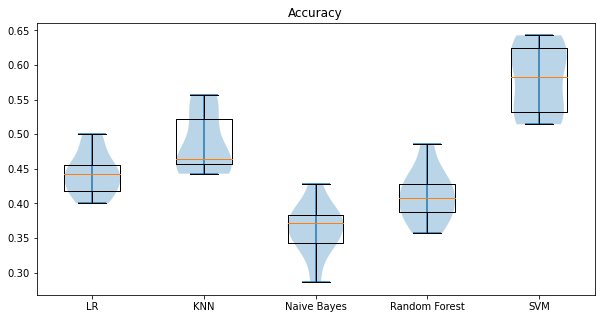

In [22]:
#Plotting the test results as boxplot
plt.figure(figsize=(10,5))
plt.violinplot(acc_score)
plt.boxplot(acc_score)
plt.xticks(range(1,len(model_name)+1),model_name)
plt.title("Accuracy")
plt.show()

#### LDA

In [23]:
acc_score = []
f1_score = []
model_name = []

#Creating a DataFrame to store performance of each model
df_results = pd.DataFrame(columns=['Name','F1 Mean','F1 STD',
                                   'Accuracy Mean','Accuracy STD'])

#Performing cross validation for each model to find the best model
i=0
for name,model in models_lda:
    #Cross Validation
    accuracy = cross_val_score(model,lda_transformed,y_train_label,cv=10,
                             scoring='accuracy',
                            n_jobs=-1,verbose=10)

    f1 = cross_val_score(model,lda_transformed,y_train_label,cv=10,
                             scoring='f1_weighted',
                            n_jobs=-1,verbose=10)
    #Appending the result to list
    acc_score.append(accuracy)
    f1_score.append(f1)
    model_name.append(name)
    #Appending the performance to the Dataframe
    df_results.loc[i] = [name,
                         f1.mean(),
                         f1.std(),
                         accuracy.mean(),
                         accuracy.std()]
    i += 1
#Displaying the performance of the cross validation    
df_results.sort_values(by=['F1 Mean'],ascending=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0380s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0343s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

,Name,F1 Mean,F1 STD,Accuracy Mean,Accuracy STD
1,KNN,0.985499,0.017337,0.985694,0.016903
4,SVM,0.982764,0.015452,0.982836,0.015382
2,Naive Bayes,0.977304,0.022677,0.977122,0.023204
3,Random Forest,0.977032,0.020459,0.977122,0.018285
0,LR,0.966650,0.031119,0.967122,0.030660


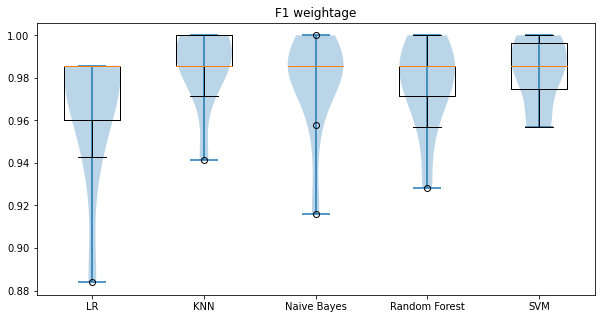

In [24]:
#Plotting the test results as boxplot
plt.figure(figsize=(10,5))
plt.violinplot(f1_score)
plt.boxplot(f1_score)
plt.xticks(range(1,len(model_name)+1),model_name)
plt.title("F1 weightage")
plt.show()

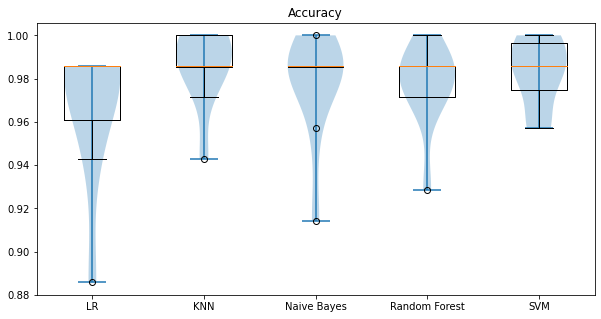

In [25]:
#Plotting the test results as boxplot
plt.figure(figsize=(10,5))
plt.violinplot(acc_score)
plt.boxplot(acc_score)
plt.xticks(range(1,len(model_name)+1),model_name)
plt.title("Accuracy")
plt.show()

## 3.3 Hyperparameter tuning

#### LDA

In [39]:
from sklearn.model_selection import RandomizedSearchCV

knn_clasifier = KNeighborsClassifier()
# Parameters to be considered
param_grid = {'leaf_size': list(range(1,50)),
             'p': [1,2]}

random_search_knn = RandomizedSearchCV(estimator=knn_clasifier, 
                 param_distributions=param_grid, 
                 cv=10,   # use any cross validation technique 
                 verbose=10, 
                 scoring='f1_weighted') 
random_search_knn.fit(lda_transformed,y_train_label)

best_model_knn_lda = random_search_knn.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START leaf_size=15, p=2.........................................
[CV 1/10; 1/10] END .......................leaf_size=15, p=2; total time=   0.0s
[CV 2/10; 1/10] START leaf_size=15, p=2.........................................
[CV 2/10; 1/10] END .......................leaf_size=15, p=2; total time=   0.0s
[CV 3/10; 1/10] START leaf_size=15, p=2.........................................
[CV 3/10; 1/10] END .......................leaf_size=15, p=2; total time=   0.0s
[CV 4/10; 1/10] START leaf_size=15, p=2.........................................
[CV 4/10; 1/10] END .......................leaf_size=15, p=2; total time=   0.0s
[CV 5/10; 1/10] START leaf_size=15, p=2.........................................
[CV 5/10; 1/10] END .......................leaf_size=15, p=2; total time=   0.0s
[CV 6/10; 1/10] START leaf_size=15, p=2.........................................
[CV 6/10; 1/10] END .......................lea

[CV 7/10; 6/10] END ........................leaf_size=3, p=2; total time=   0.0s
[CV 8/10; 6/10] START leaf_size=3, p=2..........................................
[CV 8/10; 6/10] END ........................leaf_size=3, p=2; total time=   0.0s
[CV 9/10; 6/10] START leaf_size=3, p=2..........................................
[CV 9/10; 6/10] END ........................leaf_size=3, p=2; total time=   0.0s
[CV 10/10; 6/10] START leaf_size=3, p=2.........................................
[CV 10/10; 6/10] END .......................leaf_size=3, p=2; total time=   0.0s
[CV 1/10; 7/10] START leaf_size=16, p=1.........................................
[CV 1/10; 7/10] END .......................leaf_size=16, p=1; total time=   0.0s
[CV 2/10; 7/10] START leaf_size=16, p=1.........................................
[CV 2/10; 7/10] END .......................leaf_size=16, p=1; total time=   0.0s
[CV 3/10; 7/10] START leaf_size=16, p=1.........................................
[CV 3/10; 7/10] END ........

In [40]:
print('='*50)
print("best estimator: " + str(random_search_knn.best_estimator_))
print("best params: " + str(random_search_knn.best_params_))
print('best score:', random_search_knn.best_score_)
print('='*50)

best estimator: KNeighborsClassifier(leaf_size=15)
best params: {'p': 2, 'leaf_size': 15}
best score: 0.9854985023501648


In [43]:
svc_classifier = SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}



random_search_svm = RandomizedSearchCV(estimator=svc_classifier, 
                 param_distributions=param_grid, 
                 cv=10,   # use any cross validation technique 
                 verbose=10, 
                 scoring='f1_weighted') 
random_search_svm.fit(lda_transformed,y_train_label)

best_model_svm_lda = random_search_svm.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 1/10; 1/10] END ..............C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 2/10; 1/10] END ..............C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 3/10; 1/10] END ..............C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 4/10; 1/10] END ..............C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 5/10; 1/10] END ..............C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 6/10; 1/10] START C=1, gamma=0.1, kernel=rbf................................
[CV 6/10; 1/10] END ..............C=1, gamma=0

[CV 1/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV 2/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 2/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV 3/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 3/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV 4/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 4/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV 5/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 5/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV 6/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 6/10; 6/10] END ..............C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV 7/10; 6/10] START C=100, gamma=1, kernel=rbf................................
[CV 7/10; 6/10] END ........

In [44]:
print('='*50)
print("best estimator: " + str(random_search_svm.best_estimator_))
print("best params: " + str(random_search_svm.best_params_))
print('best score:', random_search_svm.best_score_)
print('='*50)

best estimator: SVC(C=100, gamma=0.0001)
best params: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}
best score: 0.9843548127064752


#### PCA

In [45]:
svc_classifier = SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}



random_search_svm = RandomizedSearchCV(estimator=svc_classifier, 
                 param_distributions=param_grid, 
                 cv=10,   # use any cross validation technique 
                 verbose=10, 
                 scoring='f1_weighted') 
random_search_svm.fit(pca_transformed,y_train_label)

best_model_svm_pca = random_search_svm.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 1/10; 1/10] END ............C=100, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 2/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 2/10; 1/10] END ............C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV 3/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 3/10; 1/10] END ............C=100, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 4/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 4/10; 1/10] END ............C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV 5/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 5/10; 1/10] END ............C=100, gamma=0.1, kernel=rbf; total time=   0.2s
[CV 6/10; 1/10] START C=100, gamma=0.1, kernel=rbf..............................
[CV 6/10; 1/10] END ............C=100, gamma=0

[CV 1/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 2/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 2/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 3/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 3/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 4/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 4/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 5/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 5/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 6/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 6/10; 6/10] END ...............C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV 7/10; 6/10] START C=10, gamma=1, kernel=rbf.................................
[CV 7/10; 6/10] END ........

In [46]:
print('='*50)
print("best estimator: " + str(random_search_svm.best_estimator_))
print("best params: " + str(random_search_svm.best_params_))
print('best score:', random_search_svm.best_score_)
print('='*50)

best estimator: SVC(C=100, gamma=0.001)
best params: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
best score: 0.5953833756665469


In [47]:
rf_classifier = RandomForestClassifier()

param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}



random_search_rf = RandomizedSearchCV(estimator=rf_classifier, 
                 param_distributions=param_grid, 
                 cv=10,   # use any cross validation technique 
                 verbose=10, 
                 scoring='f1_weighted') 
random_search_rf.fit(pca_transformed,y_train_label)

best_model_rf_pca = random_search_rf.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 1/10; 1/10] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.2s
[CV 2/10; 1/10] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 2/10; 1/10] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.1s
[CV 3/10; 1/10] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/10; 1/10] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.2s
[CV 4/10; 1/10] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 4/10; 1/10] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   1.4s
[CV 5/10; 1/10] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 5/10; 1/10] END

[CV 10/10; 4/10] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175; total time=   2.1s
[CV 1/10; 5/10] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 1/10; 5/10] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75; total time=   0.6s
[CV 2/10; 5/10] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 2/10; 5/10] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75; total time=   0.6s
[CV 3/10; 5/10] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 3/10; 5/10] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75; total time=   0.5s
[CV 4/10; 5/10] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 4/10; 5/10] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=75; total time=   0.5s
[CV 5/10; 5/10] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_

[CV 1/10; 9/10] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.4s
[CV 2/10; 9/10] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 2/10; 9/10] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.4s
[CV 3/10; 9/10] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 3/10; 9/10] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.4s
[CV 4/10; 9/10] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 4/10; 9/10] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.3s
[CV 5/10; 9/10] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 5/10; 9/10] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   2.3s
[CV 6/10; 9/10] START max_depth=20, min_samples_leaf=1, min_samp

In [48]:
print('='*50)
print("best estimator: " + str(random_search_rf.best_estimator_))
print("best params: " + str(random_search_rf.best_params_))
print('best score:', random_search_rf.best_score_)
print('='*50)

best estimator: RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=175)
best params: {'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 15}
best score: 0.4539060320217657


## 4. Evaluation on test set

### LDA

In [37]:
test_label = label_encoder.transform(test_y)
test_scaling = scaler.transform(test_X)
test_lda = lda.transform(test_scaling)

#### SVM

Accuracy of the model is 20.0%


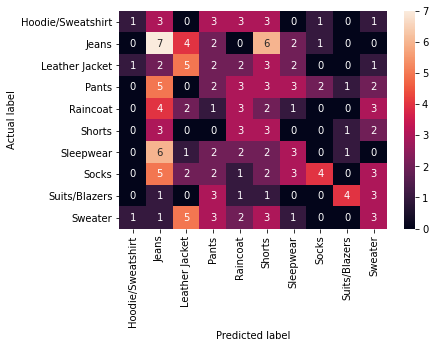

In [52]:
from sklearn.metrics import accuracy_score

y_predict = best_model_svm_lda.predict(test_lda)
cmatrix = confusion_matrix(test_label,y_predict)
accuracy = accuracy_score(test_label,y_predict)
print(f'Accuracy of the model is {accuracy*100}%')

# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
#plt.title(model[0])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### KNN

Accuracy of the model is 21.142857142857142%


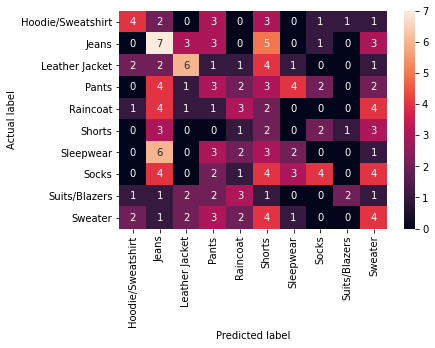

In [53]:
y_predict = best_model_knn_lda.predict(test_lda)
cmatrix = confusion_matrix(test_label,y_predict)
accuracy = accuracy_score(test_label,y_predict)
print(f'Accuracy of the model is {accuracy*100}%')

# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### PCA

In [54]:
test_pca = pca.transform(test_scaling)

#### SVM

Accuracy of the model is 61.71428571428571%


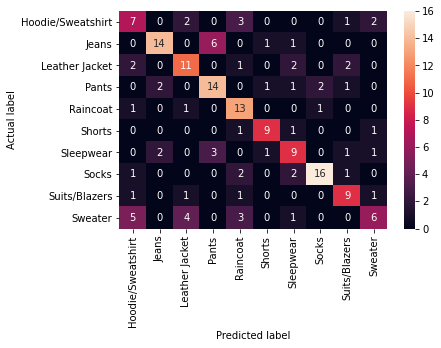

In [56]:
y_predict = best_model_svm_pca.predict(test_pca)
cmatrix = confusion_matrix(test_label,y_predict)
accuracy = accuracy_score(test_label,y_predict)
print(f'Accuracy of the model is {accuracy*100}%')

# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
#plt.title(model[0])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Random Forest

Accuracy of the model is 45.714285714285715%


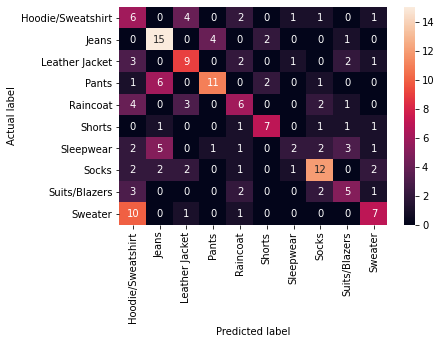

In [60]:
y_predict = best_model_rf_pca.predict(test_pca)
cmatrix = confusion_matrix(test_label,y_predict)
accuracy = accuracy_score(test_label,y_predict)
print(f'Accuracy of the model is {accuracy*100}%')

# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
#plt.title(model[0])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 5. Final model

## Metrics

Test set

Accuracy on test set is 61.71428571428571%

                   precision    recall  f1-score   support

Hoodie/Sweatshirt       0.41      0.47      0.44        15
            Jeans       0.78      0.64      0.70        22
   Leather Jacket       0.58      0.61      0.59        18
            Pants       0.61      0.67      0.64        21
         Raincoat       0.54      0.81      0.65        16
           Shorts       0.75      0.75      0.75        12
        Sleepwear       0.53      0.53      0.53        17
            Socks       0.84      0.73      0.78        22
    Suits/Blazers       0.60      0.69      0.64        13
          Sweater       0.55      0.32      0.40        19

         accuracy                           0.62       175
        macro avg       0.62      0.62      0.61       175
     weighted avg       0.63      0.62      0.61       175



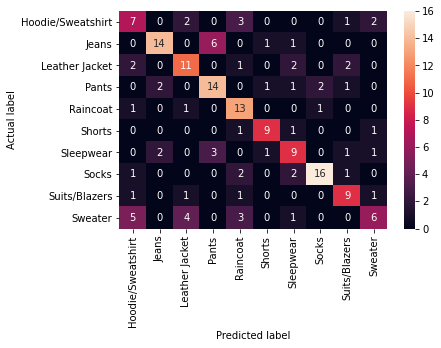

In [66]:
from sklearn.metrics import classification_report

print('Test set\n')
y_predict = best_model_svm_pca.predict(test_pca)
print(f'Accuracy on test set is {accuracy_score(test_label,y_predict)*100}%\n')
print(classification_report(test_label, y_predict, target_names=label_order))

cmatrix = confusion_matrix(test_label,y_predict)
# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Train set

Accuracy on train set is 100.0%

                   precision    recall  f1-score   support

Hoodie/Sweatshirt       1.00      1.00      1.00        71
            Jeans       1.00      1.00      1.00        68
   Leather Jacket       1.00      1.00      1.00        71
            Pants       1.00      1.00      1.00        63
         Raincoat       1.00      1.00      1.00        68
           Shorts       1.00      1.00      1.00        75
        Sleepwear       1.00      1.00      1.00        64
            Socks       1.00      1.00      1.00        77
    Suits/Blazers       1.00      1.00      1.00        71
          Sweater       1.00      1.00      1.00        71

         accuracy                           1.00       699
        macro avg       1.00      1.00      1.00       699
     weighted avg       1.00      1.00      1.00       699



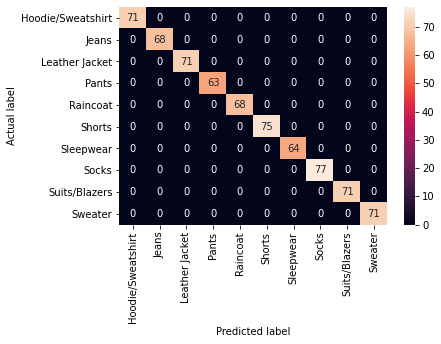

In [71]:
print('Train set\n')
y_predict = best_model_svm_pca.predict(pca_transformed)
print(f'Accuracy on train set is {accuracy_score(y_train_label,y_predict)*100}%\n')
print(classification_report(y_train_label, y_predict, target_names=label_order))

cmatrix = confusion_matrix(y_train_label,y_predict)
# create heatmap
sns.heatmap(pd.DataFrame(cmatrix,columns=label_order,index=label_order), annot=True, fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Pickle model and transformers

In [70]:
import pickle 

with open('Binfiles/model_svm.pkl','wb') as file:
    pickle.dump(best_model_svm_pca,file)
    
with open('Binfiles/scaler.pkl','wb') as file:
    pickle.dump(scaler,file)
    
with open('Binfiles/pca.pkl','wb') as file:
    pickle.dump(pca,file)